<a href="https://colab.research.google.com/github/sauddy/DPNNet-Bayesian/blob/main/Keras_tuner_hyperparameters_DPNNet_Fixed_particles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
    This notebook is used to post-process the data obtained from the 
    FARGO3D simulations for the Disk-Planet interaction with Fixed particle size. 
    We shall build "Disk Planet Neural Network - Bayesian".

    Objective : Is to tune the hyperparameters for the MLP 
                architecture used for the DPNNet-Bayesian using keras-tuner
                Since we have updated our data and we will be 
                implementing Bayesian NN, we will tune the hyperparameters on 
                the regular MLP before implementing the BNN

    Code : The code is modified from DPNNet-1.0
    
    Modification : 27 July 2021-- This script is same as the one used DPNNet-Bayesian
    FIxed Particle simulations. We implement the hyperparameter tuning with keras-tuner

    We have build a dpnnet_class in this updated version where we optimise the Network
    over 100 trials

    Links to the previous papers: 
    ArXiv Link : Paper1 :  https://arxiv.org/abs/2007.13779
                 Paper2 :  https://arxiv.org/abs/2107.09086
'''

# Author :  Sayantan
# Created : July 24 2021


## Modules for data handling
import glob
import pandas as pd
import numpy as np

## Modules for plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

## Modules for tensorflow model development
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers



print(tf.__version__)


## new module additions for hyper parameter tuning
!pip install  -U keras-tuner
import keras_tuner as kt



2.5.0
     |████████████████████████████████| 96 kB 3.0 MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-py3-none-any.whl size=9568 sha256=cde52bac7b75af8ef7c5ba679afdb0c3cc57e766a1c3efb561005526708c3491
  Stored in directory: /root/.cache/pip/wheels/38/5c/e0/13003e68c17f403af40b92a24d20171b95fef13b0fdaba833c
Successfully built kt-legacy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Path_gdrive= '/content/drive/MyDrive/DPNNet_FP/FP_bayesian_MLP_version/'
import os
os.chdir(Path_gdrive)

## Import the dpnnet_class
import dpnnet_class as dp
print("Creating the folders")
## Folders to save the filtered data
!mkdir -p data_folder
!mkdir -p figures ## to save the figures

We have imported the dpnnet_class
Creating the folders


In [ ]:
# ### Data preparation if raw darta is provided otherwise use the next kernel for saved filtered data directly ###

# dataset_path = '/content/drive/MyDrive/DPNNet_FP/Fixed_particle_data/'
# dataset_path ='/content/drive/MyDrive/DPNNet_FP/fixed_particle_data_21June/'
dataset_path ='/content/drive/MyDrive/DPNNet_FP/analysis_output_3000_FI/'

Model = dp.dpnnet(data_path=dataset_path)
dataset = Model.data_filtering()


dataset        # to take a look at the dataset 

,Planet_Mass,Epsilon,Alpha,Stokes,Aspect_Ratio,SigmaSlope,Dust_gap_1,Dust_gap_2,Flaring_index
0,95.666667,0.0980,0.00341,0.0342,0.0362,1.0600,0.826,0.00,0.0785
1,95.000000,0.0299,0.00176,0.0146,0.0901,0.4920,0.547,0.15,0.1730
2,86.000000,0.0223,0.00894,0.0719,0.0558,0.4600,0.815,0.00,0.2310
3,49.000000,0.0579,0.00260,0.0128,0.0494,0.9580,0.773,0.00,0.1060
4,37.666667,0.0520,0.00394,0.0941,0.0275,0.1300,0.818,0.00,0.1780
...,...,...,...,...,...,...,...,...,...
1108,87.000000,0.0905,0.00441,0.0956,0.0531,0.1810,0.916,0.00,0.1660
1109,54.000000,0.0978,0.00993,0.0749,0.0560,0.0832,0.753,0.00,0.0329
1110,91.333333,0.0220,0.00758,0.0801,0.0685,0.5080,0.773,0.00,0.1110
1111,102.000000,0.0209,0.00347,0.0871,0.0331,0.8290,0.853,0.00,0.0121


In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = Model.data_processing()
# X_train_scaled


The feature variables are normalized for better scaling
[INFO] data processing done, returns the splitted data...
[INFO] X_train and X_test data are normalized ...


In [ ]:
## Building the DPNNet MLP model for keras tuner##

def build_model(hp):
  model = keras.Sequential()
  model.add(layers.Flatten(input_shape=[len(X_train_scaled.keys())]))

  model.add(layers.Dense(units=hp.Int('unit1',min_value = 32,max_value= 256,step=32), activation=tf.nn.relu,kernel_regularizer=regularizers.l2(0.0001),input_shape=[len(X_train_scaled.keys())]))
  model.add(layers.Dense(units=hp.Int('unit2',min_value = 32,max_value= 256,step=32), activation=tf.nn.relu,kernel_regularizer=regularizers.l2(0.0001)))
  # model.add(layers.Dense(1))
  
  
  # for i in range(hp.Int('layers',2,4)):
  #   model.add(layers.Dense(units=hp.Int('unit'+str(i),min_value = 32,max_value= 256,step=32), activation=tf.nn.relu,kernel_regularizer=regularizers.l2(0.0001)))
  model.add(layers.Dense(1))
  
  model.compile(loss='mean_squared_error',
                optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-3,1e-4])) , metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [ ]:
## using keras tuner to explore the hyperparameter space
## Select the Number of Trials
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) ## early stopping is used to minimize overfitting
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=100,executions_per_trial=2, directory='Tuner_Model',project_name='DPNNet_Bayesian')


In [ ]:
tuner.search_space_summary() ## checking the summary

Search space summary
Default search space size: 3
unit1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
unit2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [ ]:
## Select the Epoch and the Validation Split
tuner.search(X_train_scaled,y_train,epochs=1000,validation_split = 0.2, verbose=1,callbacks=[early_stop])

Trial 64 Complete [00h 02m 00s]
val_loss: 272.4387969970703

Best val_loss So Far: 257.19139862060547
Total elapsed time: 01h 37m 26s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary() ## the best 10 models

Results summary
Results in Tuner_Model/DPNNet_Bayesian
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
unit1: 32
unit2: 224
learning_rate: 0.001
Score: 257.19139862060547
Trial summary
Hyperparameters:
unit1: 64
unit2: 128
learning_rate: 0.001
Score: 257.73780059814453
Trial summary
Hyperparameters:
unit1: 64
unit2: 64
learning_rate: 0.001
Score: 260.3539733886719
Trial summary
Hyperparameters:
unit1: 224
unit2: 160
learning_rate: 0.001
Score: 262.59178161621094
Trial summary
Hyperparameters:
unit1: 160
unit2: 96
learning_rate: 0.001
Score: 264.2572937011719
Trial summary
Hyperparameters:
unit1: 64
unit2: 192
learning_rate: 0.001
Score: 264.53639221191406
Trial summary
Hyperparameters:
unit1: 160
unit2: 160
learning_rate: 0.001
Score: 264.5674133300781
Trial summary
Hyperparameters:
unit1: 256
unit2: 64
learning_rate: 0.001
Score: 264.6504211425781
Trial summary
Hyperparameters:
unit1: 128
unit2: 224
learning_rate: 0.001
Score: 265.5312

In [ ]:
print(tuner.get_best_hyperparameters()[0].values)
best_hp = tuner.get_best_hyperparameters()[0]
best_hp['learning_rate']
# model = tuner.hypermodel.build(best_hp)

{'unit1': 32, 'unit2': 224, 'learning_rate': 0.001}


0.001

In [ ]:
# ## Train the best model
# best_model = tuner.get_best_models()[0]
# best_model.build()
# best_model.summary()
# model = best_model

model = Model.build_model(unit1=best_hp['unit1'],unit2=best_hp['unit2'],learning_rate =best_hp['learning_rate'] )
history = model.fit(X_train_scaled,y_train,epochs=1000,validation_split = 0.2, verbose=1,callbacks=[early_stop])


We are now using the DPNNet Architecture
The feature variables are normalized for better scaling
[INFO] data processing done, returns the splitted data...
[INFO] X_train and X_test data are normalized ...
Epoch 1/1000
22/22 [==============================] - 20s 29ms/step - loss: 6042.7412 - mean_absolute_error: 72.4916 - mean_squared_error: 6042.7412 - val_loss: 6027.1792 - val_mean_absolute_error: 70.9590 - val_mean_squared_error: 6027.1792
Epoch 2/1000
22/22 [==============================] - 0s 3ms/step - loss: 5805.0426 - mean_absolute_error: 70.6211 - mean_squared_error: 5805.0426 - val_loss: 5400.7251 - val_mean_absolute_error: 66.4531 - val_mean_squared_error: 5400.7251
Epoch 3/1000
22/22 [==============================] - 0s 3ms/step - loss: 4925.1514 - mean_absolute_error: 64.1681 - mean_squared_error: 4925.1514 - val_loss: 4280.5068 - val_mean_absolute_error: 57.7006 - val_mean_squared_error: 4280.5068
Epoch 4/1000
22/22 [==============================] - 0s 3ms/step - loss:

In [ ]:
## Optional checking the history from the trained set
model.summary()
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 8)                 0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 32)                288       
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 224)               7392      
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 1)                 225       
Total params: 7,905
Trainable params: 7,905
Non-trainable params: 0
_________________________________________________________________


,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
106,147.422226,9.028905,147.422226,278.880646,11.911683,278.880646,106
107,146.485046,8.977401,146.485046,276.800018,11.861273,276.800018,107
108,144.434036,8.945398,144.434036,281.363983,11.935559,281.363983,108
109,143.589432,8.898923,143.589432,282.159515,11.982672,282.159515,109
110,142.055389,8.878694,142.055389,284.893982,12.012546,284.893982,110


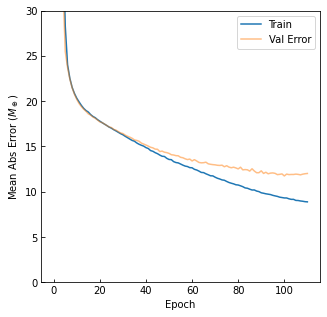

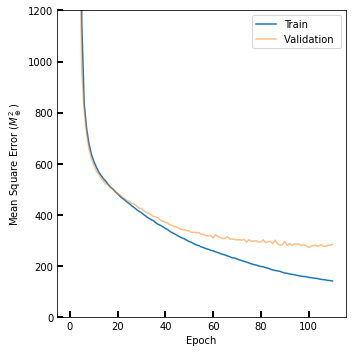

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(5,5))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error ($M_\oplus$)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train ')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],alpha=0.5,
           label = 'Val Error')
  plt.ylim([0,30])
  plt.legend()

  plt.figure(figsize=(5,5))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error ($M_\oplus^2$)')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],alpha=0.5,
           label = 'Validation ')
  plt.ylim([0,1200])
#   plt.xlim([0,700])
#   plt.yscale("log")
  plt.legend()
  plt.tick_params(labelsize=10)
  plt.tick_params(axis='both', which='major',length=6, width=2)
  plt.tick_params(axis='both', which='minor',length=3, width=1.3)  
  plt.tight_layout()
  plt.savefig('figures/validation_loss.pdf',format='pdf',dpi=300)
  plt.show()

  
plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Testing set Mean Square Error: {:5.2f} ".format(mse))
print("Testing set Root Mean Square Error: {:5.2f} M_Earth".format(np.sqrt(mse)))
print("Testing set Mean Abs Error: {:5.2f} M_Earth".format(mae))
print("Testing set Loss : {:5.2f} M_Earth".format(loss))

Testing set Mean Square Error: 185.83 
Testing set Root Mean Square Error: 13.63 M_Earth
Testing set Mean Abs Error: 10.68 M_Earth
Testing set Loss : 185.83 M_Earth


In [ ]:
## Use list comprehension tp predict over the test dataset for 10 times.
yhat = [model.predict(X_test_scaled).flatten() for _ in range(10)]

## Predcited vs Actually mass plot

In [ ]:
df  =pd.DataFrame(yhat).T
df['y'] = y_test.values
df.head()

,0,1,2,3,4,5,6,7,8,9,y
0,15.393574,15.393574,15.393574,15.393574,15.393574,15.393574,15.393574,15.393574,15.393574,15.393574,27.866667
1,73.352875,73.352875,73.352875,73.352875,73.352875,73.352875,73.352875,73.352875,73.352875,73.352875,73.333333
2,95.798721,95.798721,95.798721,95.798721,95.798721,95.798721,95.798721,95.798721,95.798721,95.798721,92.333333
3,52.395618,52.395618,52.395618,52.395618,52.395618,52.395618,52.395618,52.395618,52.395618,52.395618,39.000000
4,107.208374,107.208374,107.208374,107.208374,107.208374,107.208374,107.208374,107.208374,107.208374,107.208374,119.000000


In [ ]:
import itertools
sample_preds = list(itertools.chain.from_iterable([[(j,x[-1]) for j in x if j != x[-1]]for x in df .values]))

In [ ]:
sample_preds[:15]

[(15.393573760986328, 27.866666666666667),
 (15.393573760986328, 27.866666666666667),
 (15.393573760986328, 27.866666666666667),
 (15.393573760986328, 27.866666666666667),
 (15.393573760986328, 27.866666666666667),
 (15.393573760986328, 27.866666666666667),
 (15.393573760986328, 27.866666666666667),
 (15.393573760986328, 27.866666666666667),
 (15.393573760986328, 27.866666666666667),
 (15.393573760986328, 27.866666666666667),
 (73.35287475585938, 73.33333333333333),
 (73.35287475585938, 73.33333333333333),
 (73.35287475585938, 73.33333333333333),
 (73.35287475585938, 73.33333333333333),
 (73.35287475585938, 73.33333333333333)]

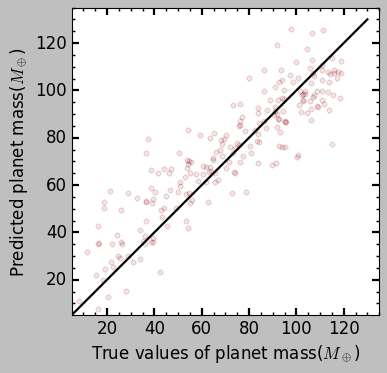

In [ ]:
plt.style.use('classic')
plt.figure(figsize = (5,5))
# test_predictions = model.predict(normed_test_data).flatten()
# plt.scatter(test_labels, test_predictions,s=30,marker='d',color='r')
plt.scatter([x[1] for x in sample_preds],[x[0] for x in sample_preds],alpha = 0.01,c = 'r')
plt.xlabel(r'True values of planet mass($M_\oplus$)', fontsize=15)
plt.ylabel(r'Predicted planet mass($M_\oplus$)',fontsize=15)
plt.axis('equal')
plt.axis('square')
plt.xlim(5,135)
plt.ylim(5,135)
# plt.xlim([0.6,plt.xlim()[1]])
# plt.ylim([0.6,plt.xlim()[1]])
_ = plt.plot([0, 130], [0, 130],linewidth=2,c='k')

plt.minorticks_on() 
plt.tick_params(labelsize=15)
plt.tick_params(axis='both', which='major',length=6, width=2)
plt.tick_params(axis='both', which='minor',length=3, width=1.3)
plt.tight_layout()
plt.savefig('figures/predicted_correlation.pdf',format='pdf',dpi=300)
# plt.savefig('predicted_correlation.eps',format='eps',dpi=300)


In [ ]:
# # THE SD is the mean of the root mean square error (root of MSE)
# SD = np.sqrt(mse)

In [ ]:
## One test case for the demonstration in the paper
test_index = 120
# print(test_dataset.iloc[[test_index]])
print("Actual Planet Mass is ", y_test.iloc[[test_index]])
X_test_scaled.iloc[[4]]
print("Predicted Planet Mass is " , model.predict(X_test_scaled.iloc[[test_index]]))

Actual Planet Mass is  1078    92.666667
Name: Planet_Mass, dtype: float64
Predicted Planet Mass is  [[76.59602]]
